In [1]:
from typing import Optional
from pathlib import Path
import yaml  
import os
import pandas as pd
import requests
import csv
from tqdm.auto import tqdm
from loguru import logger
from typing import List, Optional
from Bio import SeqIO
from Bio.PDB import PDBList, PDBParser, PPBuilder, PDBIO
from Bio.PDB.Polypeptide import three_to_one, standard_aa_names
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import PDB
import re
import matplotlib.pyplot as plt
import logging

from utils import standard_amino_acids, remove_water, remove_ion, remove_dna

In [10]:
log_file = "/home/light/mqy/ncaa/data/error_log.txt"
logging.basicConfig(filename=log_file, level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')

In [15]:
ROOT_DIR = Path("../data")
MSA_PATH = ROOT_DIR / "没跑过msa的" / "3" / "ss_complex_supplement"
MSA_PATH.mkdir(exist_ok=True)
# df_complex = pd.read_csv(ROOT_DIR / "pdbid.csv")

In [12]:
class PDBDownloader:
    def __init__(self, pdb_dir) -> None:
        self.pdbl = PDBList()
        self.pdbl.download_pdb_files = True
        self.pdb_dir = pdb_dir

    def fetch_pdb(self, pdb_id: str, exp_id: str):
        try:
            self.pdbl.retrieve_pdb_file(
                pdb_id, file_format="pdb", pdir=self.pdb_dir / exp_id
            )
            return True
        except:
            print(e)
            print(f"Failed to download PDB for {pdb_id}")
            return None

    def fetch_fasta(self, pdb_id: str, exp_id: str) -> Optional[str]:
        """下载fasta文件"""
        url = f"https://www.rcsb.org/fasta/entry/{pdb_id}"
        response = requests.get(url)
        _path = Path(self.pdb_dir) / exp_id / f"{exp_id[:-1]}.fasta"

        try:
            if response.status_code == 200:
                with _path.open("w+") as f:
                    f.write(response.text)
                return True
        except Exception as e:
            print(e)
            print(f"Failed to download FASTA for {pdb_id}")
            return None

In [5]:
# # 下载原始数据
# pdbdownloader = PDBDownloader(pdb_dir=MSA_PATH)
# num_success = 0
# errors = []
# with tqdm(df_complex["PDB ID"].to_list(), total=len(df_complex)) as pbar:
#     for complex_id in pbar:
#         pbar.set_description(f"Processing {complex_id}")
#         protein_id = complex_id[:-1]
#         peptide_id = complex_id

#         status_pdb = pdbdownloader.fetch_pdb(pdb_id=protein_id, exp_id=complex_id)
#         status_fasta = pdbdownloader.fetch_fasta(pdb_id=protein_id, exp_id=complex_id)
#         if status_pdb and status_fasta:
#             num_success += 1
#         else:
#             errors.append(
#                 complex_id
#             )
# print(f"总共有 {len(df_complex)}, 成功 {num_success}")
# print(f"errors:")
# print(errors)

In [6]:
# 判断是否是多肽单体
# for exp_dir in MSA_PATH.iterdir():
#     fasta_path = exp_dir / f"{exp_dir.name[:-1]}.fasta"
#     records = SeqIO.parse(fasta_path, "fasta")
#     num = 0
#     for record in records:
#         num += 1
#     if num == 1:
#         flag = exp_dir / "is_monomer.flag"
#         flag.mkdir(exist_ok=True)

In [2]:
# # 创建monomer.csv

# def find_and_write_monomer_flag_folders(root_folder, output_csv):
#     # Create or open the CSV file
#     with open(output_csv, mode='w', newline='') as csv_file:
#         writer = csv.writer(csv_file)
#         writer.writerow(['Folder Name'])  # Write header row

#         # Traverse the root folder
#         for subdir, dirs, files in os.walk(root_folder):
#             for dir_name in dirs:
#                 subdir_path = os.path.join(subdir, dir_name)
#                 # Check if 'is_monomer.flag' file exists in the subdir
#                 if 'is_monomer.flag' in os.listdir(subdir_path):
#                     writer.writerow([dir_name])

# # Define the root folder to start the search and the output CSV file
# root_folder = '/home/light/mqy/ncaa/data/MSA'
# output_csv = '/home/light/mqy/ncaa/data/monomer.csv'

# find_and_write_monomer_flag_folders(root_folder, output_csv)


In [8]:
def write_fasta_no_newline(f_path, record):
    """因为 RFAA 无法读取带换行符号的 FASTA 文件"""
    try:
        with open(f_path, "w") as handle:  
            # 写入 header 行  
            handle.write(">" + record.description + "\n")  
            # 写入序列，确保没有换行符  
            handle.write(str(record.seq) + "\n")
    except Exception as e:
        print(e)


def get_protein_fasta(exp_dir: Path):
    """
    从复合物fasta中抽取蛋白质fasta
    1ai1P-protein-1.fasta
    1ai1P-protein-2.fasta
    """
    exp_id = exp_dir.name
    complex_fasta_file = exp_dir / f"{exp_id[:-1]}.fasta"
    records = SeqIO.parse(complex_fasta_file, "fasta")
    for i, record in enumerate(records):
        match = re.search(r"Chains?\s+([A-Z\[\]auth ,]+)", record.description)
        if match:
            chain_list = match.group(1)
            chains = re.findall(r"[A-Z]", chain_list)
        if exp_id[-1] in chains:
            continue
        protein_fasta_file = exp_dir / f"{exp_id[:-1]}-protein-{i+1}.fasta"
        # SeqIO.write([record], protein_fasta_file, "fasta")
        write_fasta_no_newline(protein_fasta_file, record)

def get_pep_pdb(exp_dir: Path):
    """
    保存 pep pdb
    1ai1P-pep-pdb
    """
    raw_pdb_path = exp_dir / f"{exp_dir.name[:-1]}.pdb"
    parser = PDBParser()
    structure = parser.get_structure(f"{exp_dir.name[:-1]}", raw_pdb_path)
    remove_water(structure)
    remove_dna(structure)
    remove_ion(structure)
    pep = structure[0][f"{exp_dir.name[-1]}"]

    io = PDBIO()
    io.set_structure(pep)
    pep_pdb_file = exp_dir / f"{exp_dir.name[:-1]}-pep.pdb"
    io.save(str(pep_pdb_file))

def get_peptide_fasta(exp_dir: Path):
    """
    生成多肽的 fasta , 有 X 版
    1ai1P-pep-ncaa.fasta
    """
    exp_id = exp_dir.name
    pep_pdb_file = exp_dir / f"{exp_id}.pdb"  # 🌈 exp_dir / f"{exp_id[:-1]}-pep.pdb"
    pep_fasta_file = exp_dir / f"{exp_id}-pep-pdb.fasta" # 🌈 f"{exp_id[:-1]}-pep-ncaa.fasta"
    parser = PDB.PDBParser()
    structure = parser.get_structure(exp_id, pep_pdb_file) # 🌈 exp_id[:-1]
    for chain in structure[0]:
    # chain = structure[0][exp_id] # 🌈 exp_id[:-1]
        sequence = "".join(
            [
                (
                    three_to_one(residue.resname)
                    if residue.id[0] == " " and residue.resname in standard_amino_acids
                    else "X"
                )
                for residue in chain
            ]
        )

    seq_object = Seq(sequence)
    record = SeqRecord(seq_object, id=exp_id, description=f"{exp_id}")
    write_fasta_no_newline(pep_fasta_file, record)
    # records.append(record)
    # SeqIO.write(records, pep_fasta_file, "fasta")

def get_ncaa_from_pdb(exp_dir: Path) -> List[str]:
    """从 pdb 文件中获得 ncaa 的三字母标识"""
    exp_id = exp_dir.name
    parser = PDB.PDBParser()
    pep_pdb_file = exp_dir / f"{exp_id[:-1]}-pep.pdb"
    structure = parser.get_structure(exp_id[:-1], pep_pdb_file)
    non_standard_residues = []
    chain = structure[0][f"{exp_id[-1]}"]
    for residue in chain:
        if residue.get_resname() not in standard_amino_acids:
            non_standard_residues.append(residue.get_resname())
    return non_standard_residues

def get_aa_from_fasta(exp_dir: Path):
    """从 ncaa fasta 到 aa fasta, 只要取 get_aa_from_fasta[0]"""
    exp_id = exp_dir.name
    pattern = None
    pep_fasta_file = exp_dir / f"{exp_id[:-1]}-pep-ncaa.fasta"
    complex_fasta_file = exp_dir / f"{exp_id[:-1]}.fasta"
    try:
        # 获取模式
        for record in SeqIO.parse(pep_fasta_file, "fasta"):
            sequence = str(record.seq)
            regex = re.sub("X", "[A-Z]", sequence)
            pattern = re.compile(regex)
            break
        for record in SeqIO.parse(complex_fasta_file, "fasta"):
            match = re.search(r"Chains?\s+([A-Z\[\]auth ,]+)", record.description)
            if match:
                chain_list = match.group(1)
                if exp_id[-1] in chain_list:
                    for match in pattern.finditer(str(record.seq)):
                        match_seq = match.group() # 总fasta文件中的多肽链
                        positions = [
                            i + 1
                            for i, char in enumerate(match_seq)
                            if char != sequence[i] or char == "X"
                        ]
                        matched_letters = [match_seq[i - 1] for i in positions]  # ncaa的位置
        return matched_letters, match_seq
    except Exception as e:
        logging.exception(f"Error processing {exp_id}")
        # print(f"{exp_id}: {e}")

def get_peptide_aa_fasta(exp_dir: Path):
    """
    从 ncaa fasta 到 aa fasta
    1ai1P-pep-aa.fasta
    """
    if get_aa_from_fasta(exp_dir):
        _, match_seq = get_aa_from_fasta(exp_dir)
        pep_fasta_aa_file = exp_dir / f"{exp_dir.name[:-1]}-pep-aa.fasta"
        SeqIO.write(SeqRecord(Seq(match_seq), id=exp_dir.name, description=""), pep_fasta_aa_file, "fasta")

# def aa(exp_dir: Path):
#     """
#     从 ncaa fasta 到 aa fasta
#     1ai1P-pep-aa.fasta
#     """
#     pep_fasta_file = exp_dir / f"{exp_id[:-1]}-pep-ncaa.fasta"
#     for record in SeqIO.parse(pep_fasta_file, "fasta"):
#         sequence = str(record.seq)


In [13]:
# 遍历 MSA文件夹
for exp_dir in tqdm(MSA_PATH.iterdir(), total=len(list(MSA_PATH.iterdir()))):
    # get_protein_fasta(exp_dir)
    # get_pep_pdb(exp_dir)
    get_peptide_fasta(exp_dir)
    # ncaa_name = get_ncaa_from_pdb(exp_dir)
    # print(f"{exp_dir.name}'s ncaa: {ncaa_name}")
    # get_peptide_aa_fasta(exp_dir)

  0%|          | 0/15 [00:00<?, ?it/s]

In [16]:
# 筛选出MSA里面pep-aa.fasta 中有X的
b = 0
for exp_dir in tqdm(MSA_PATH.iterdir(), total=len(list(MSA_PATH.iterdir()))):
    if exp_dir.name == "error":
        continue
    fasta_dir = exp_dir / f"{exp_dir.name}-pep.fasta"
    fasta_list  = list((SeqIO.parse(fasta_dir, "fasta")))
    fasta = str(fasta_list[0].seq)
    # a = fasta.count("X")
    # if a == 0:
    #     print(exp_dir.name)
    #     b += 1
    if "X" in fasta:
        print(exp_dir.name,fasta)
# print(b)

  0%|          | 0/44 [00:00<?, ?it/s]

4W4Z APYCVYRXSWSCX
2C9T GCCSDPRCAWRCX
6BAE XCQFDLSTRRLKCX
2UZ6 GCCSRPPCILNNPDLCX
5CO5 GCCSHPACAGNNQHICX
7N43 GCCSHPACNVNNPHICGX


In [34]:
c = 0
b = 0
for exp_dir in tqdm(MSA_PATH.iterdir(), total=len(list(MSA_PATH.iterdir()))):
    if exp_dir.name == "error":
        continue
    fasta_dir = exp_dir / f"{exp_dir.name[:-1]}-pep-ncaa.fasta"
    predict_pdb = exp_dir / "predict" / f"{exp_dir.name}.pdb"
    fasta_list  = list((SeqIO.parse(fasta_dir, "fasta")))
    fasta = str(fasta_list[0])
    a = fasta.count("X")
    monomer_flag = exp_dir / "is_monomer.flag"
    if a == 1 and (not monomer_flag.exists()) and predict_pdb.exists():
        b += 1
    if (not monomer_flag.exists()) and predict_pdb.exists():
        c += 1
print(b,c)

  0%|          | 0/376 [00:00<?, ?it/s]

110 146


In [36]:
MSA_PATH = Path("/home/light/mqy/ncaa/data/highfold_predict/no_cc2")
a = 0
for exp_dir in tqdm(MSA_PATH.iterdir(), total=len(list(MSA_PATH.iterdir()))):
    a += 1
print(a)

  0%|          | 0/160 [00:00<?, ?it/s]

160


In [14]:
# 遍历各组实验
# for exp_dir in tqdm(MSA_PATH.iterdir(), total=len(list(MSA_PATH.iterdir()))):
#     get_protein_fasta(exp_dir)
#     get_peptide_fasta(exp_dir)
#     get_peptide_aa_fasta(exp_dir)
#     break

In [23]:
def build_mapping(msa_dir: Path) -> dict:
    ncaa_to_aa_map = {}
    for exp_dir in msa_dir.iterdir():
        print(exp_dir.name)
        #ncaa2aa_dict = {}
        ncaa_resname = get_ncaa_from_pdb(exp_dir)
        try:
            aa, _ = get_aa_from_fasta(exp_dir)
        except Exception as e:
            aa = [None] * len(ncaa_resname)
        print(ncaa_resname, aa)
        for i,resname in enumerate(ncaa_resname):
            if resname not in ncaa_to_aa_map or (ncaa_to_aa_map.get(resname) is None and aa[i] is not None):
                ncaa_to_aa_map[resname] = aa[i]
        #ncaa2aa_dict[exp_dir.name] = [ncaa_resname, aa]
    return ncaa_to_aa_map

def save_mapping(save_path: Path, msa_dir: Path):
    ncaa_to_aa_map = build_mapping(msa_dir)
    mapping_df = pd.DataFrame(list(ncaa_to_aa_map.items()), columns=['ncaa', 'aa'])
    mapping_df['sm'] = pd.NA
    mapping_df['sm pos'] = pd.NA
    mapping_df.to_csv(save_path, index=False)

    # mapping_df["ncaa"] = list(ncaa_to_aa_map.keys())
    # mapping_df["aa"] = list(ncaa_to_aa_map.values())
    # mapping_df["sm"] = ''
    # mapping_df["sm pos"] = ''
    # mapping_df.to_csv(save_path, index=False)

save_path = Path("/home/light/mqy/ncaa/data/sm-info.csv")
map = save_mapping(save_path, MSA_PATH)



2d3hF
['HYP', 'HYP'] ['P', 'P']
1fu5B
['PTR', 'PTR'] ['Y', 'Y']
3g7lP
['M3L'] ['K']
1er8I
['DHI'] ['H']
2ci9M
['PTR'] ['Y']
3mukD
['PRK'] ['X']
3fquC
['SEP'] ['S']
1eeoB
['PTR', 'NH2'] ['Y', 'X']
4jfxP
['PTR'] ['Y']
2iuiC
['PTR'] ['Y']
1guwB
['MLY', 'MLY'] ['K', 'K']
2dvrQ
['ALY'] ['K']
2x4xF
['M3L'] ['K']
4c78C
['ALY'] ['K']
2wp1P
['ALY'] ['K']
2vpeP
['MLY'] ['K']
2jqcA
['HYP'] ['P']
3a0mD
['HYP'] ['P']
2bqzB
['MLZ'] ['K']
1yc5B
['ALY'] ['K']
3n9qC
['MLY'] ['K']
1lf8E
['SEP'] ['S']
4h3hF
['SEP'] ['S']
3olrE
['PTR'] ['Y']
3b95P
['MLY'] [None]
3bgmC
['SEP'] ['S']
2a0tB
['TPO'] ['T']
4b9wP
['2MR'] ['R']
2w5zC
['MLY'] ['K']
2kvmB
['MLY'] ['K']
2lo6B
['SEP', 'SEP'] ['S', 'S']
2q8yB
['TPO', 'PTR'] ['T', 'Y']
2m0oB
['M3L'] ['K']
2m7jA
['DPR'] ['P']
3k27B
['M3L'] ['K']
2rfiP
['MLY'] ['K']
3tzdT
['MLY'] ['K']
3idnC
['HOX'] ['X']
3u5pM
['M3L', 'ALY', 'ALY'] ['K', 'K', 'K']
4imjF
['SEP'] ['S']
3u4sC
['M3L'] ['K']
3lqiT
['MLY'] ['K']
1spsD
['PTR'] ['Y']
4lorD
['HYP', 'HYP', 'HYP', 'HYP', 'HYP', '

In [14]:
class RFAAConfig:
    def __init__(self, base_file: Optional[str] = None) -> None:
        if not base_file:
            self.base_file = Path("/home/light/mqy/RoseTTAFold-All-Atom/rf2aa/config/inference/base.yaml")
        else:
            self.base_file = Path(base_file)
        self._read_base_config()
    
    def _read_base_config(self):
        with self.base_file.open("r") as f:  
            self.confg_dict = yaml.safe_load(f) 

    def _deep_update(self, base_dict, new_dict):  
        """  
        递归地更新base_dict，使用new_dict中的数据。  
        如果new_dict中有相同的键，且对应的值是字典，则递归合并。  
        """  
        for key, value in new_dict.items():  
            if isinstance(value, dict):  
                # 如果value是字典，递归地调用_deep_update  
                if key in base_dict and isinstance(base_dict[key], dict):  
                    self._deep_update(base_dict[key], value)  
                else:  
                    base_dict[key] = value  
            else:  
                base_dict[key] = value  

    def update_config(self, new_config):  
        """  
        使用new_config更新confg_dict。  
        如果new_config中有嵌套的字典，则递归地合并它们。  
        """  
        self._deep_update(self.confg_dict, new_config)  

    def save_config(self, save_path):
        with open(save_path, 'w') as file:  
            yaml.dump(self.confg_dict, file)

In [15]:
class ExpItem:
    def __init__(
        self,
        exp_id: str,
        root_dir: str = "../data/MSA",
        mapping_dict_file: Optional[str] = "sm-info.csv",
    ) -> None:
        self.exp_id = exp_id
        self.root_dir = Path(root_dir)
        self.exp_dir = self.root_dir / self.exp_id

        self.is_monomer = False

        self.complex_fasta_file = self.exp_dir / f"{self.exp_id[:-1]}.fasta"
        self.complex_pdb_file = self.exp_dir / f"{self.exp_id[:-1]}.pdb"
        self.pep_pdb_file = self.exp_dir / f"{self.exp_id[:-1]}-pep.pdb"
        self.pep_fasta_file = self.exp_dir / f"{self.exp_id[:-1]}-pep-ncaa.fasta"
        self.pep_fasta_aa_file = self.exp_dir / f"{self.exp_id[:-1]}-pep-aa.fasta"

        self.mapping_df = pd.read_csv(self.root_dir.parent / mapping_dict_file)

    def __repr__(self) -> str:
        return self.exp_id

    def _get_info_by_ncaa(self, ncaa_name: str, target_name: str):
        try:
            return self.mapping_df.loc[
                self.mapping_df["ncaa"] == ncaa_name, target_name
            ][0]
        except Exception as e:
            print(
                f"Failed to get info for {ncaa_name}'s property {target_name}, since {e}"
            )
            return None

    @property
    def sm(self):
        return [self._get_info_by_ncaa(ncaa, "sm") for ncaa in self.ncaa]

    @property
    def sm_pos(self):
        return [self._get_info_by_ncaa(ncaa, "sm_pos") for ncaa in self.ncaa]

    @property
    def aa(self):
        return [self._get_info_by_ncaa(ncaa, "aa") for ncaa in self.ncaa]

    @property
    def ncaa(self) -> List[str]:
        parser = PDB.PDBParser()
        structure = parser.get_structure(self.exp_id[:-1], self.pep_pdb_file)
        non_standard_residues = []
        chain = structure[0][f"{self.exp_id[-1]}"]

        for residue in chain:
            if residue.get_resname() not in standard_amino_acids:
                non_standard_residues.append(residue.get_resname())
        return non_standard_residues

    @property
    def num_ncaa(self) -> int:
        return len(self.ncaa)

    @property
    def x_pos(self) -> List[int]:
        fa_seq = SeqIO.read(self.pep_fasta_file, "fasta")
        pos = [i + 1 for i, char in enumerate(fa_seq.seq) if char == "X"]
        return pos

    @property
    def num_protein_chains(self):
        return len(self.protein_fasta_files)

    @property
    def protein_fasta_files(self):
        pattern = f"{self.exp_id[:-1]}-protein-\d+\.fasta"
        return [
            filename
            for filename in os.listdir(self.exp_dir)
            if re.search(pattern, filename)
        ]

    def convert_number_to_letter(self, number, start_letter="A"):
        # 将起始字母转换为ASCII码
        start_ascii = ord(start_letter)
        # 将数字转换为对应的ASCII码，并转换为字符
        letter_ascii = start_ascii + number
        # 确保转换后的ASCII码在字母范围内（如果需要的话）
        letter_ascii = max(min(letter_ascii, ord("Z")), ord("A"))
        return chr(letter_ascii)

    def generate_config(self, mode="aa") -> None:
        if mode == "aa":
            
            pep_aa_file = self.exp_dir.absolute() / f"{self.exp_id[:-1]}-pep-aa.fasta"
            protein_inputs = {
                self.convert_number_to_letter(i): dict(
                    [("fasta_file", f"{self.exp_dir.absolute() / pff}")]
                )
                for i, pff in enumerate(self.protein_fasta_files)
            }
            protein_inputs.update(
                {
                    self.convert_number_to_letter(self.num_protein_chains): {
                        "fasta_file": str(pep_aa_file)
                    }
                }
            )
            new_config = {
                "job_name": f"{self.exp_id}",
                "protein_inputs": protein_inputs,
                "database_params": {
                    "num_cpus": 64,
                    "mem": 1024,
                },
                "loader_params": {"MAXCYCLE": 10},
                "output_path": f"{self.exp_dir.absolute() / 'predict'}",
            }
            config_path = "config_aa.yaml"
        else:
            new_config = {}
            config_path = "config_ncaa.yaml"

        config = RFAAConfig()
        config.update_config(new_config)
        config.save_config(self.exp_dir / config_path)

In [8]:
def peptide_length(msa_path):
    """多肽链长度分布"""
    length_dict = {}
    for exp_dir in msa_path.iterdir():
        _pep_ncaa_path = exp_dir / f"{exp_dir.name[:-1]}-pep-ncaa.fasta"
        records = SeqIO.parse(_pep_ncaa_path, "fasta")
        for record in records:
            if length_dict.get(len(str(record.seq))) is None:
                length_dict[len(str(record.seq))] = 1
            else:
                length_dict[len(str(record.seq))] += 1
    length_max = max(length_dict.keys())
    length_min = min(length_dict.keys())
    return length_dict, length_max, length_min

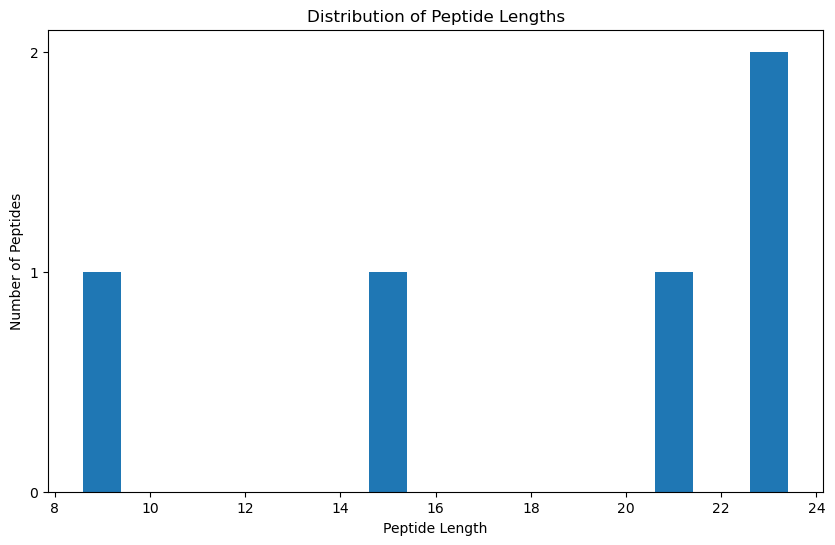

In [14]:
tmp_path = Path("/home/light/zsl/ncaa/data/MSA/tmp")
pep_length, _, _ = peptide_length(tmp_path)
pep_length

lengths = list(pep_length.keys())
counts = list(pep_length.values())
plt.figure(figsize=(10, 6))
plt.bar(lengths, counts)
plt.xlabel("Peptide Length")
plt.ylabel("Number of Peptides")
plt.title("Distribution of Peptide Lengths")
plt.yticks(range(0, max(counts) + 1))
plt.show()

In [16]:
# 遍历各组实验
exp_list = []
for exp_dir in MSA_PATH.iterdir():
    exp = ExpItem(exp_dir.name)
    exp.generate_config()
    exp_list.append(exp)

In [23]:
one_exp = exp_list[2]
print(one_exp.ncaa)
print(one_exp.num_ncaa)
print(one_exp.x_pos)

['AIB']
1
[7]


In [ ]:
# 测试
print(exp.exp_id)
print(exp.ncaa)
print(exp.aa)
print(exp.x_pos)
print(exp.sm)
print(exp.sm_pos)